In [1]:
from mne.io import read_epochs_eeglab
from mne.preprocessing import ICA
from src.metadata_parser import EEGLAB
import warnings
import matplotlib.pyplot as plt

import mne
import numpy as np
from mne.viz import plot_sensors
from scipy import stats

from mne.utils import _pl,logger

In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="pymatreader")

In [3]:
data_path = 'ICA-ASR/study02/study02_p18_prep.set'
EEG = EEGLAB(data_path)

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")
    data = mne.io.read_epochs_eeglab(data_path)

Extracting parameters from C:\Users\20gun\OneDrive\Desktop\Demo for Lab Presentation\ICA-ASR\study02\study02_p18_prep.set...
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [5]:
picks = list(set(range(20)).difference({data.ch_names.index('FPz'),data.ch_names.index('Fz')}))
interested_channels = [data.ch_names[chan_idx] for chan_idx in picks]

In [6]:
def fit_ica(data_as_raw_array,return_as_numpy = False,plot_data = False,return_ica_object = False,n_components = len(picks)):
    data_filt = data_as_raw_array.copy().filter(l_freq=1.0, h_freq=None);
    
    ica = ICA(n_components=n_components, max_iter="auto");
    ica.fit(data_filt);

    if plot_data:
        ica.plot_sources(data_filt,show_scrollbars = False)
    
    if return_as_numpy:
        
        if return_ica_object:
            return ica.get_sources(data_filt).get_data(),ica

        return ica.get_sources(data_filt).get_data()

    elif return_ica_object:

        if return_as_numpy:

            return ica.get_sources(data_filt).get_data(),ica

        return ica

In [7]:
def _pick_sources(data, include, exclude, n_pca_components):
        """Aux function."""
        if n_pca_components is None:
            n_pca_components = ica.n_pca_components
        data = ica._pre_whiten(data)
        exclude = ica._check_exclude(exclude)
        _n_pca_comp = ica._check_n_pca_components(n_pca_components)
        n_ch, _ = data.shape

        max_pca_components = ica.pca_components_.shape[0]
        if not ica.n_components_ <= _n_pca_comp <= max_pca_components:
            raise ValueError(
                f"n_pca_components ({_n_pca_comp}) must be >= "
                f"n_components_ ({ica.n_components_}) and <= "
                "the total number of PCA components "
                f"({max_pca_components})."
            )

        logger.info(
            f"    Transforming to ICA space ({ica.n_components_} "
            f"component{_pl(ica.n_components_)})"
        )

        # Apply first PCA
        if ica.pca_mean_ is not None:
            data -= ica.pca_mean_[:, None]

        sel_keep = np.arange(ica.n_components_)
        if include not in (None, []):
            sel_keep = np.unique(include)
        elif exclude not in (None, []):
            sel_keep = np.setdiff1d(np.arange(ica.n_components_), exclude)

        n_zero = ica.n_components_ - len(sel_keep)
        logger.info(f"    Zeroing out {n_zero} ICA component{_pl(n_zero)}")

        # Mixing and unmixing should both be shape (self.n_components_, 2),
        # and we need to put these into the upper left part of larger mixing
        # and unmixing matrices of shape (n_ch, _n_pca_comp)
        pca_components = ica.pca_components_[:_n_pca_comp]
        assert pca_components.shape == (_n_pca_comp, n_ch)
        assert (
            ica.unmixing_matrix_.shape
            == ica.mixing_matrix_.shape
            == (ica.n_components_,) * 2
        )
        unmixing = np.eye(_n_pca_comp)
        unmixing[: ica.n_components_, : ica.n_components_] = ica.unmixing_matrix_
        unmixing = np.dot(unmixing, pca_components)

        logger.info(
            f"    Projecting back using {_n_pca_comp} "
            f"PCA component{_pl(_n_pca_comp)}"
        )
        mixing = np.eye(_n_pca_comp)
        mixing[: ica.n_components_, : ica.n_components_] = ica.mixing_matrix_
        mixing = pca_components.T @ mixing
        assert mixing.shape == unmixing.shape[::-1] == (n_ch, _n_pca_comp)

        # keep requested components plus residuals (if any)
        sel_keep = np.concatenate(
            (sel_keep, np.arange(ica.n_components_, _n_pca_comp))
        )
        proj_mat = np.dot(mixing[:, sel_keep], unmixing[sel_keep, :])
        data = np.dot(proj_mat, data)


        assert proj_mat.shape == (n_ch,) * 2

        if ica.pca_mean_ is not None:
            data += ica.pca_mean_[:, None]

        # restore scaling
        if ica.noise_cov is None:  # revert standardization
            data *= ica.pre_whitener_
        else:
            data = np.linalg.pinv(ica.pre_whitener_, rcond=1e-14) @ data

        return data


In [8]:
def inverse_process(data,include,exclude,n_pca_components,ica):

    if n_pca_components is None:
        n_pca_components = ica.n_pca_components
            
    _n_pca_comp = ica._check_n_pca_components(n_pca_components)
    n_ch, _ = data.shape

    max_pca_components = ica.pca_components_.shape[0]
    if not ica.n_components_ <= _n_pca_comp <= max_pca_components:
        raise ValueError(
            f"n_pca_components ({_n_pca_comp}) must be >= "
            f"n_components_ ({ica.n_components_}) and <= "
            "the total number of PCA components "
            f"({max_pca_components})."
        )


    sel_keep = np.arange(ica.n_components_)
    if include not in (None, []):
        sel_keep = np.unique(include)
    elif exclude not in (None, []):
        sel_keep = np.setdiff1d(np.arange(ica.n_components_), exclude)

    pca_components = ica.pca_components_[:_n_pca_comp]

    mixing = np.eye(_n_pca_comp)
    mixing[: ica.n_components_, : ica.n_components_] = ica.mixing_matrix_
    mixing = pca_components.T @ mixing

    # keep requested components plus residuals (if any)
    sel_keep = np.concatenate(
        (sel_keep, np.arange(ica.n_components_, _n_pca_comp))
    )
    proj_mat = mixing[sel_keep,:]
    data = np.dot(proj_mat, data)

    if ica.noise_cov is None:
        data *= ica.pre_whitener_

    return data

In [9]:
def forward_process(data,include,exclude,n_pca_components):

    if n_pca_components is None:
        n_pca_components = ica.n_pca_components
            
    data = ica._pre_whiten(data)
    exclude = ica._check_exclude(exclude)
    _n_pca_comp = ica._check_n_pca_components(n_pca_components)
    n_ch, _ = data.shape

    max_pca_components = ica.pca_components_.shape[0]
    if not ica.n_components_ <= _n_pca_comp <= max_pca_components:
        raise ValueError(
            f"n_pca_components ({_n_pca_comp}) must be >= "
            f"n_components_ ({ica.n_components_}) and <= "
            "the total number of PCA components "
            f"({max_pca_components})."
        )

    logger.info(
        f"    Transforming to ICA space ({ica.n_components_} "
        f"component{_pl(ica.n_components_)})"
    )

    # Apply first PCA
    if ica.pca_mean_ is not None:
        data -= ica.pca_mean_[:, None]

    sel_keep = np.arange(ica.n_components_)
    if include not in (None, []):
        sel_keep = np.unique(include)
    elif exclude not in (None, []):
        sel_keep = np.setdiff1d(np.arange(ica.n_components_), exclude)

    pca_components = ica.pca_components_[:_n_pca_comp]

    unmixing = np.eye(_n_pca_comp)
    unmixing[: ica.n_components_, : ica.n_components_] = ica.unmixing_matrix_
    unmixing = np.dot(unmixing, pca_components)

    # keep requested components plus residuals (if any)
    sel_keep = np.concatenate(
        (sel_keep, np.arange(ica.n_components_, _n_pca_comp))
    )
    proj_mat = unmixing[sel_keep,:]
    data = np.dot(proj_mat, data)

    return data

In [10]:
unused_blink_epochs = np.hstack((data.get_data()[5],data.get_data()[7]))[picks]

info = mne.create_info(ch_types = ['eeg']*len(interested_channels),ch_names = interested_channels,sfreq = data.info['sfreq'])
unused_blink_epochs_raw_array = mne.io.RawArray(data = unused_blink_epochs,info = info)

Creating RawArray with float64 data, n_channels=18, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    15.995 secs
Ready.


In [11]:
ica = fit_ica(unused_blink_epochs_raw_array,return_ica_object = True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)

Fitting ICA to data using 18 channels (please be patient, this may take a while)
Selecting by number: 18 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.


In [12]:
included = list(range(len(interested_channels)))
excluded = []
n_pca_components = len(interested_channels)

In [13]:
data = unused_blink_epochs

In [14]:
reconstructed_data = _pick_sources(unused_blink_epochs,included,excluded,n_pca_components)

    Transforming to ICA space (18 components)
    Zeroing out 0 ICA components
    Projecting back using 18 PCA components


In [15]:
reconstructed_data_ra = mne.io.RawArray(data = reconstructed_data,info = info)

Creating RawArray with float64 data, n_channels=18, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    15.995 secs
Ready.


In [16]:
data = forward_process(data,included,excluded,n_pca_components)

    Transforming to ICA space (18 components)


In [17]:
source_data = mne.io.RawArray(data = data,info = info)

Creating RawArray with float64 data, n_channels=18, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    15.995 secs
Ready.


Using matplotlib as 2D backend.


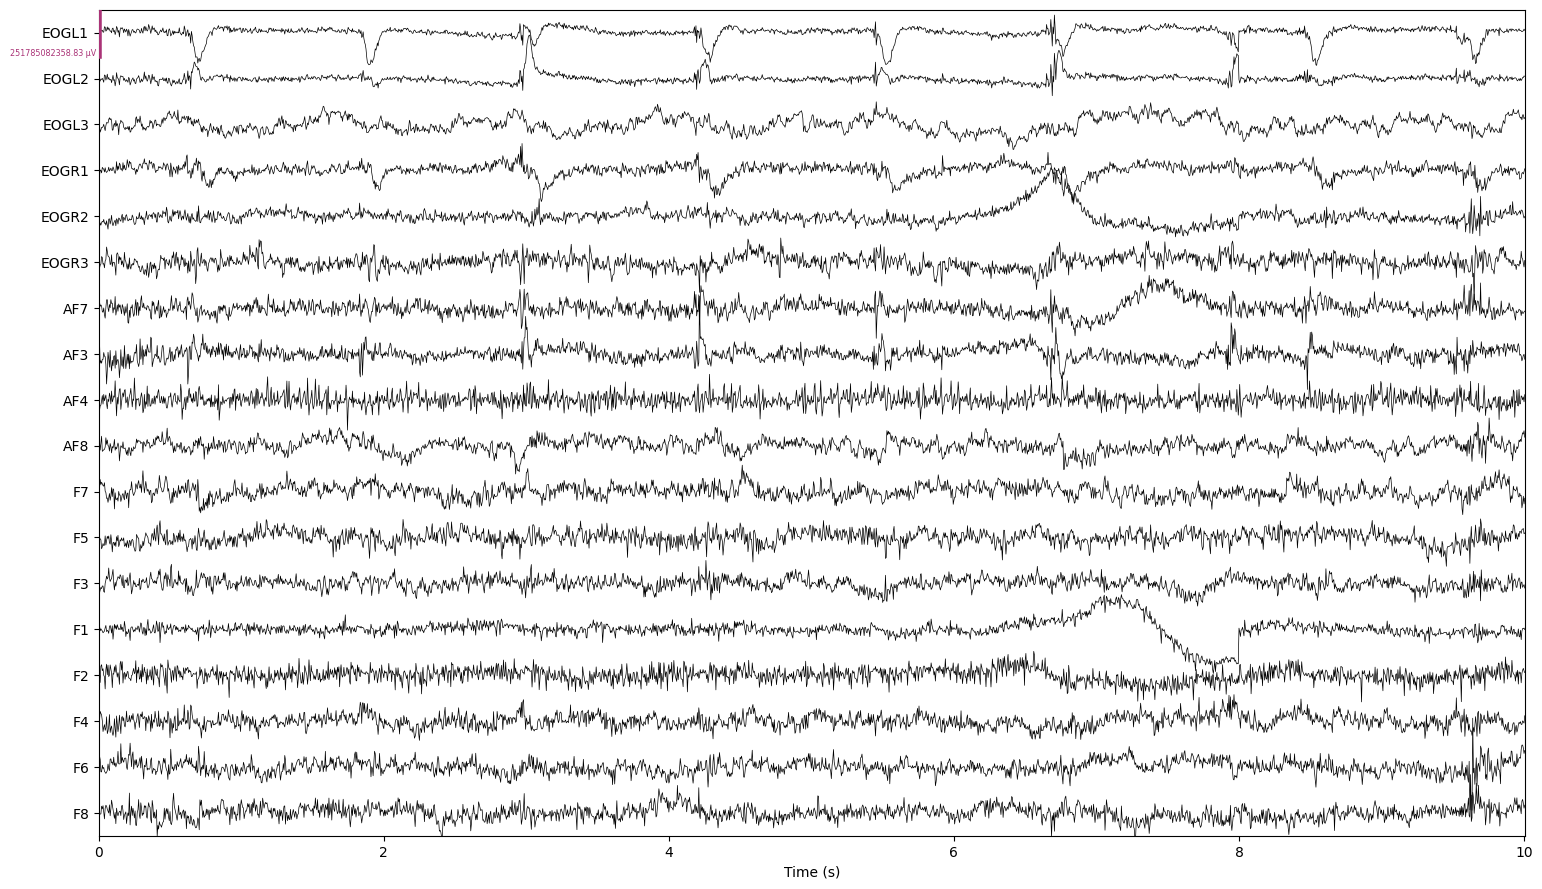

In [18]:
source_data.plot(show_scrollbars = False,scalings = {'eeg':10**5.1});

In [27]:
reconstructed_data = inverse_process(source_data.get_data(),included,excluded,n_pca_components,ica) 

In [28]:
reconstructed_data = mne.io.RawArray(data = reconstructed_data,info = info)

Creating RawArray with float64 data, n_channels=18, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    15.995 secs
Ready.


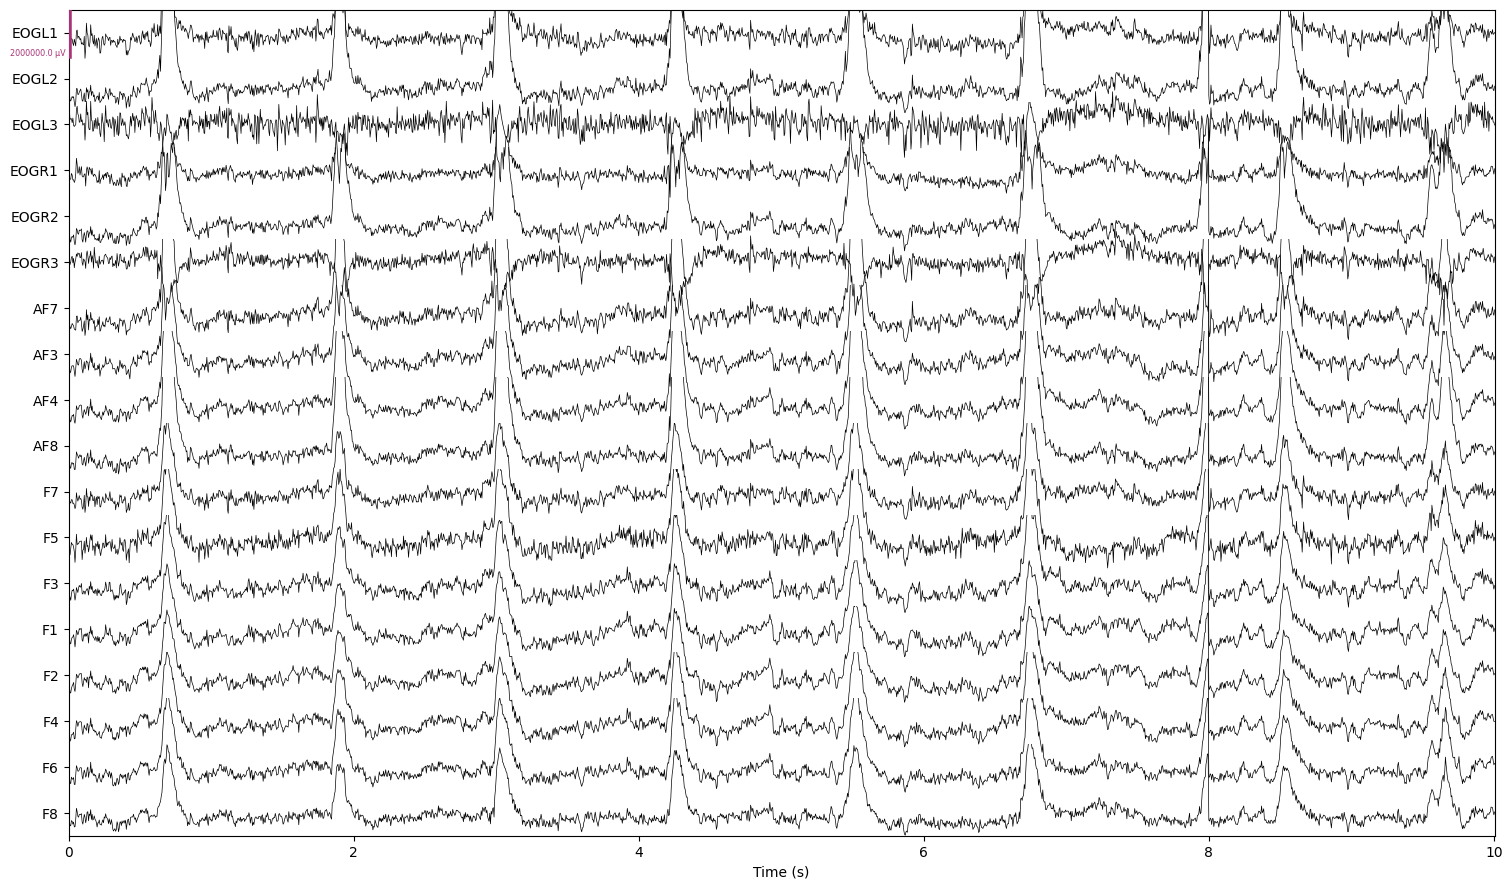

In [30]:
reconstructed_data.plot(show_scrollbars = False,scalings = {'eeg':1});